## Setup env

For Google Colaboratory only

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/vi2')

In [3]:
!pip install dpath
!pip install beautifulsoup4
!pip install elasticsearch
!pip install elasticsearch-dsl
#!pip install dill
!pip install pypandoc

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Preprocess

## Import

In [4]:
import itertools
import json
import pprint
from xml.sax import saxutils

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, IFrame, HTML

import dpath.util
from bs4 import BeautifulSoup
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, MultiSearch, Q
from elasticsearch_dsl.query import Match, MoreLikeThis

In [5]:
# display HTML within notebook
def phtml(s):
  display(HTML(s))

# pretty print dictionary as JSON
# 
# None key changes to "null"
# does not handle python sets!!
def pdict(d):
  print(json.dumps(d, indent=4))

In [6]:
def bs(s):
  return BeautifulSoup(s, 'html.parser')

pretty_printer = pprint.PrettyPrinter(indent=4)
def pp(o):
  pretty_printer.pprint(o)

In [7]:
ELASTIC_INDEX = 'rec'
ELASTIC_HOST = 'localhost:9200'
es = Elasticsearch(ELASTIC_HOST)

## Plotting toolbox

In [8]:
# histogram
def hist(series, title=None, bins=20):
    plt.figure()
    series.plot(kind='hist', bins=bins, title=title)
    plt.show()
    plt.close()
    
# box plot
def box(series, title=None):
    plt.figure()
    sns.boxplot(series).set_title(title)
    plt.show()
    plt.close()

# violin plot
def violin(series):
    plt.figure()
    sns.violinplot(series)
    plt.show()
    plt.close()

# q-q plot
def qqplot(series, title=None):
    plt.figure(figsize=[5,5])
    stats.probplot(series, plot=plt); # default is normal distribution
    plt.title(title)
    plt.show()
    plt.close()
    
# series of plots for continuous variables
def contplot(series, bins=20):
    hist(series, title=series.name, bins=bins)
    box(series)
    violin(series)
    qqplot(series)

# bar chart
def bar(series, title=None, orientation='vertical'):
    plt.figure()
    kind = 'barh' if orientation is 'horizontal' else 'bar'
    ax = series.value_counts().plot(kind=kind, title=title)
    # Annotate each bar with value count
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.tight_layout()
    plt.show()
    plt.close()

# scatter plot
def scatter(series_x, series_y, color_series=None):
    plt.figure(figsize=[8,8])
    plt.scatter(series_x, series_y, s=7, alpha=.5, label=None, c=color_series)
    plt.xlabel(series_x.name)
    plt.ylabel(series_y.name)
    plt.show()
    plt.close()

## Dataset

In [9]:
df_events = pd.read_csv('data/vi_dataset_events.csv')
df_catalog = pd.read_csv('data/vi_dataset_catalog.csv')
for dframe in [df_events, df_catalog]:
  display(dframe.head())
  dframe.info()
  print(dframe.describe(include='all'))

,customer_id,product_id,type,timestamp
0,1,19685,view_product,1527812004
1,1,19685,view_product,1527812041
2,1,19685,add_to_cart,1527812046
3,1,19685,view_product,1527812048
4,1,19685,view_product,1527812050


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653125 entries, 0 to 653124
Data columns (total 4 columns):
customer_id    653125 non-null int64
product_id     653125 non-null int64
type           653125 non-null object
timestamp      653125 non-null int64
dtypes: int64(3), object(1)
memory usage: 19.9+ MB
          customer_id     product_id          type     timestamp
count   653125.000000  653125.000000        653125  6.531250e+05
unique            NaN            NaN             3           NaN
top               NaN            NaN  view_product           NaN
freq              NaN            NaN        592299           NaN
mean     35238.833857   16286.328308           NaN  1.529080e+09
std      24765.642265    8352.079466           NaN  7.379100e+05
min          1.000000       1.000000           NaN  1.527812e+09
25%      13555.000000    8634.000000           NaN  1.528441e+09
50%      31609.000000   18780.000000           NaN  1.529045e+09
75%      55352.000000   23626.000000    

,product_id,category_id,category_path,brand,gender,description,price
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
2,3,2,Clothes,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
4,5,3,Children|Children's Footwear|Children's Sport ...,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28369 entries, 0 to 28368
Data columns (total 7 columns):
product_id       28369 non-null int64
category_id      28369 non-null int64
category_path    28369 non-null object
brand            28369 non-null object
gender           28369 non-null object
description      26927 non-null object
price            28369 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ MB
         product_id   category_id     category_path   brand gender  \
count   28369.00000  28369.000000             28369   28369  28369   
unique          NaN           NaN               322     517      5   
top             NaN           NaN  Men|Men Clothing  Adidas    Man   
freq            NaN           NaN              5078    1799   9566   
mean    14185.00000     74.630230               NaN     NaN    NaN   
std      8189.56923     62.568572               NaN     NaN    NaN   
min         1.00000      1.000000               NaN     NaN    NaN  

## Category tree

Construct full category tree - **list** is product **count**

In [10]:
PATH_CATEGORIES_COUNT = 'categories_count.npy'
categories_count = {}
try:
  categories_count = np.load(PATH_CATEGORIES_COUNT).item()
except FileNotFoundError:
  sep = '|'
  for path in df_catalog['category_path']:  
    if dpath.util.search(categories_count, path, separator=sep):
      v = dpath.util.get(categories_count, path, separator=sep)
      v[None] = v[None] + 1 if None in v else 1
      dpath.util.set(categories_count, path, v, separator=sep)
    else:
      dpath.util.new(categories_count, path, {None: 1}, separator=sep)
  np.save(PATH_CATEGORIES_COUNT, categories_count)
pdict(categories_count)

{
    "Sports": {
        "Outdoor": {
            "Outdoor Shoes": {
                "Children's Outdoor Shoes": {
                    "null": 29,
                    "Children's Outdoor Sandals": {
                        "null": 14
                    }
                },
                "Men's Outdoor Shoes": {
                    "null": 120,
                    "Men's Outdoor Sandals": {
                        "null": 13
                    }
                },
                "Women's Outdoor Shoes": {
                    "null": 101,
                    "Women's Outdoor Sandals": {
                        "null": 20
                    }
                }
            },
            "Outdoor Clothing": {
                "Women's Outdoor Clothing": {
                    "Women's Outdoor T-Shirts": {
                        "null": 31
                    },
                    "Women's Outdoor Pants": {
                        "null": 24
                    },
                   

Construct full category tree - **list** is product **id**

In [11]:
PATH_CATEGORIES = 'categories.npy'
categories = {}
try:
  categories = np.load(PATH_CATEGORIES).item()
except FileNotFoundError:
  sep = '|'
  for index,path in df_catalog['category_path'].iteritems():  
    if dpath.util.search(categories, path, separator=sep):
      v = dpath.util.get(categories, path, separator=sep)
      if None in v:
        #v[None].append(index)
        v[None].add(index) # faster set version not supported by JSON for printing
      else:
        #v[None] = [index]
        v[None] = {index}
      dpath.util.set(categories, path, v, separator=sep)
    else:
      #dpath.util.new(categories, path, {None: [index]}, separator=sep)
      dpath.util.new(categories, path, {None: {index}}, separator=sep)
  np.save('categories.npy', categories)
# TODO propose set-to-JSON method
#pdict(categories)

In [12]:
df_catalog.drop(['category_id','category_path'], axis=1, inplace=True)
display(df_catalog.head())
df_catalog.info()

,product_id,brand,gender,description,price
0,1,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
1,2,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
2,3,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
3,4,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
4,5,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28369 entries, 0 to 28368
Data columns (total 5 columns):
product_id     28369 non-null int64
brand          28369 non-null object
gender         28369 non-null object
description    26927 non-null object
price          28369 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


## Description

In [13]:
phtml(df_catalog.iloc[7]['description'])
print(df_catalog.iloc[7]['description'])

&lt;h2&gt;&lt;!-- mp_trans_rt_start id=&quot;1&quot; args=&quot;as&quot; 5 --&gt;Slazenger Canvas Infants Pump &lt;!-- mp_trans_rt_end 5 --&gt;&lt;/h2&gt; &lt;!-- mp_trans_remove_start=&quot;DE,FR,AT&quot; --&gt;&lt;br&gt;The Slazenger Canvas Infants Pump  are perfect for everyday wear, featuring a lightweight upper with stitched detail and the Slazenger logo to the heel. These Slazenger canvas shoes also benefit from a textured outsole along with elasticated laces up front for a secure and comfortable fit.  &lt;br&gt; &lt;!-- mp_trans_remove_end=&quot;DE,FR,AT&quot; --&gt;&lt;!-- mp_trans_add=&quot;DE,FR,AT&quot; &lt;!-- mp_trans_ost_start --]&gt; --&gt;&lt;br&gt;&gt; Kids canvas shoes  &lt;br&gt;&gt; Elasticated laces &lt;br&gt;&gt; Textured outsole  &lt;br&gt;&gt; Stitched detail  &lt;br&gt;&gt; Slazenger branding &lt;br&gt;&gt; Upper- textile &lt;br&gt;&gt; Lining - textile &lt;br&gt;&gt; Sole - synthetic &lt;br&gt;&gt; Textile upper and inner, synthetic sole &lt;br&gt;&lt;br&gt;&l

In [14]:
# correct &lt; &gt;
df_catalog['description'] = df_catalog['description'].apply(lambda x: saxutils.unescape(x, {'&quot;': '"'}) if pd.notnull(x) else '?')

In [15]:
# unite break lines
df_catalog['description'] = df_catalog['description'].apply(lambda x: x.replace('<br/>','<br>').replace('<br />','<br>'))

In [16]:
phtml(df_catalog.iloc[7]['description'])
print(df_catalog.iloc[7]['description'])

<h2><!-- mp_trans_rt_start id="1" args="as" 5 -->Slazenger Canvas Infants Pump <!-- mp_trans_rt_end 5 --></h2> <!-- mp_trans_remove_start="DE,FR,AT" --><br>The Slazenger Canvas Infants Pump  are perfect for everyday wear, featuring a lightweight upper with stitched detail and the Slazenger logo to the heel. These Slazenger canvas shoes also benefit from a textured outsole along with elasticated laces up front for a secure and comfortable fit.  <br> <!-- mp_trans_remove_end="DE,FR,AT" --><!-- mp_trans_add="DE,FR,AT" <!-- mp_trans_ost_start --]> --><br>> Kids canvas shoes  <br>> Elasticated laces <br>> Textured outsole  <br>> Stitched detail  <br>> Slazenger branding <br>> Upper- textile <br>> Lining - textile <br>> Sole - synthetic <br>> Textile upper and inner, synthetic sole <br><br><!-- mp_trans_add="DE,FR,AT" <!-- mp_trans_ost_end --]> -->For our full range of <a href="/kids/kids-canvas-shoes"><u>Kids Canvas Shoes</u></a> visit <br>                              <p id="dnn_ctr103511_

## Product code

In [17]:
def extract_product_code(html):
  product_code = '?'
  if pd.notnull(html):
    try:
      product_code = html.split('"productCode">')[1].split('</p>')[0].replace('Product code: ', '')
    except:
      if 'productcode' in html.lower().replace('_',''):
        print(html)
  return product_code

df_catalog['product_code'] = pd.Series(df_catalog['description'].apply(extract_product_code), index=df_catalog.index)
display(df_catalog.head())

,product_id,brand,gender,description,price,product_code
0,1,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,020014
1,2,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,020014
2,3,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,020014
3,4,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,020014
4,5,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73,021316


By product code, we identified duplicates. Many products are exactly same, just in more categories

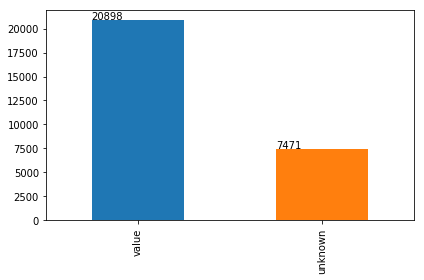

In [18]:
bar(df_catalog['product_code'].apply(lambda x: 'unknown' if x == '?' else 'value'))

In [19]:
df_catalog[df_catalog['product_code']=='?']

,product_id,brand,gender,description,price,product_code
378,379,BELLE WOMEN,Other,"<table style=""border: 0pt solid #000000; heigh...",17.43,?
379,380,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",18.83,?
380,381,NEW TLCK,Other,"<!-- TABELA 2 -->\n<table style=""width: 330px;...",8.33,?
381,382,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",10.43,?
382,383,SERGIO TODZI,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",13.23,?
383,384,AMERICAN CLUB,Other,"<!-- TABELA 2 -->\n<table style=""width: 330px;...",14.63,?
384,385,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",19.53,?
385,386,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",15.33,?
386,387,TORNA,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",10.43,?
387,388,COMER,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",31.43,?


In [20]:
phtml(df_catalog.iloc[378]['description'])
print(df_catalog.iloc[378]['description'])

The SIZE of the,36,37,38,39,40,41
LENGTH (CM),23.5,24,25,25.5,26,26.5


<table style="border: 0pt solid #000000; height: 54px;" dir="ltr" border="0" cellspacing="2" cellpadding="2" width="277" frame="border" rules="none" align="center">
<tbody style="text-align: left;">
<tr style="text-align: left;">
<td style="width: 20px; height: 20px; border: 1px solid #000000; text-align: center;" valign="middle"><span style="font-family: arial black,avant garde;"><strong>The SIZE of the</strong></span></td>
<td style="width: 20px; height: 20px; border: 1px solid #000000; text-align: center;" valign="middle">36</td>
<td style="width: 20px; height: 20px; border: 1px solid #000000; text-align: center;" valign="middle">37</td>
<td style="width: 20px; height: 20px; border: 1px solid #000000; text-align: center;" valign="middle">38</td>
<td style="width: 20px; height: 20px; border: 1px solid #000000; text-align: center;" valign="middle">39</td>
<td style="width: 20px; height: 20px; border: 1px solid #000000; text-align: center;" valign="middle">40</td>
<td style="width: 20p

We have seen that product code is missing especially for shoes.

Let's unite duplicates by single id per unique product. We reflect it also to events log.

In [21]:
for index, product_code, product_id in df_catalog.filter(['product_code', 'product_id']).itertuples(name=None):
  if product_code == '?':
    df_catalog.at[index, 'product_code'] = 'x{}'.format(product_id)

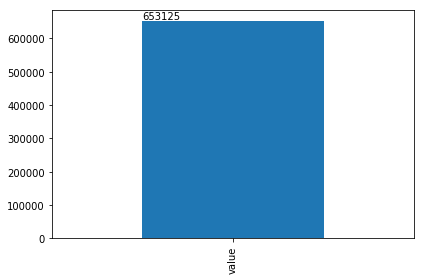

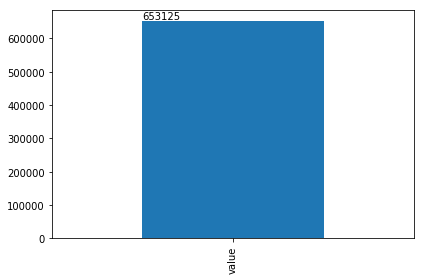

In [22]:
for col in ['product_id', 'customer_id']:
  bar(df_events[col].apply(lambda x: 'unknown' if pd.isnull(x) else 'value'))

In [23]:
df_events = df_events.merge(df_catalog, on='product_id', how='left', copy=False)
display(df_events.head())

,customer_id,product_id,type,timestamp,brand,gender,description,price,product_code
0,1,19685,view_product,1527812004,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370
1,1,19685,view_product,1527812041,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370
2,1,19685,add_to_cart,1527812046,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370
3,1,19685,view_product,1527812048,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370
4,1,19685,view_product,1527812050,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370


Duplicates are not supported only by same product code. In fact, all 4 main attributes are totally equal.

In [24]:
DUPLICATE_COLS = ['brand','gender','description','price']
df_catalog.drop_duplicates(DUPLICATE_COLS, inplace=True)
display(df_catalog.head())

,product_id,brand,gender,description,price,product_code
0,1,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,020014
4,5,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73,021316
5,6,Lonsdale,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",12.53,023060
6,7,Dunlop,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",9.03,028027
7,8,Slazenger,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",4.20,028170


In [25]:
display(df_events.loc[69])

customer_id                7
product_id             13690
type            view_product
timestamp         1527865432
brand                   2117
gender                 Other
description                ?
price                  23.87
product_code          x13690
Name: 69, dtype: object

In [26]:
df_events.rename(index=str, columns={"product_id": "product_id_original"}, inplace=True)

In [27]:
df_events = df_events.merge(df_catalog.filter((DUPLICATE_COLS + ['product_id'])), on=DUPLICATE_COLS, how='left', copy=False)
display(df_events.head())

,customer_id,product_id_original,type,timestamp,brand,gender,description,price,product_code,product_id
0,1,19685,view_product,1527812004,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370,19685
1,1,19685,view_product,1527812041,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370,19685
2,1,19685,add_to_cart,1527812046,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370,19685
3,1,19685,view_product,1527812048,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370,19685
4,1,19685,view_product,1527812050,Full Circle,Woman,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",18.13,354370,19685


In [28]:
display(df_events.loc[69])

customer_id                       7
product_id_original           13690
type                   view_product
timestamp                1527865432
brand                          2117
gender                        Other
description                       ?
price                         23.87
product_code                 x13690
product_id                    13688
Name: 69, dtype: object

In [29]:
df_events.drop(DUPLICATE_COLS, axis=1, inplace=True)
display(df_events.head())

,customer_id,product_id_original,type,timestamp,product_code,product_id
0,1,19685,view_product,1527812004,354370,19685
1,1,19685,view_product,1527812041,354370,19685
2,1,19685,add_to_cart,1527812046,354370,19685
3,1,19685,view_product,1527812048,354370,19685
4,1,19685,view_product,1527812050,354370,19685


We both significantly reduced product catalog size and increased number of events per pair product and customer.

## Extract attributes: name

In [30]:
def extract_name(html):
  name = '?'
  if html != '?':
    # normally observed name "h2", occasionally 1st "strong"
    for tag in ['h2', 'strong']:
      element = bs(html).find(tag)
      if element:
        name = element.get_text() # BeautifulSoap already ignores HTML comments!
        break
  return name

df_catalog['name'] = pd.Series(df_catalog['description'].apply(extract_name), index=df_catalog.index)
display(df_catalog.filter(['name']).head())

,name
0,Firetrap Rhino Infant Boots
4,Nike Air Max Ivo Infant Girl Trainers
5,Lonsdale Camden Infant Boys Trainers
6,Dunlop Infant Canvas High Top Trainers
7,Slazenger Canvas Infants Pump


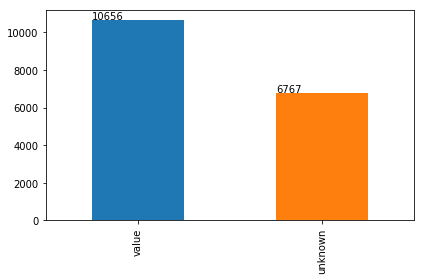

In [31]:
bar(df_catalog['name'].apply(lambda x: 'unknown' if x == '?' else 'value'))

## Extract attributes: desc

Description text

In [32]:
def extract_desc(html):
  if html == '?':
    return '?'
  return ''.join(c for c in bs(html).get_text() if c.isalnum() or c == ' ')

df_catalog['desc'] = pd.Series(df_catalog['description'].apply(extract_desc), index=df_catalog.index)
display(df_catalog.filter(['desc']).head())

,desc
0,Firetrap Rhino Infant Boots These Firetrap Rhi...
4,Nike Air Max Ivo Infant Girl Trainers Get a gr...
5,Lonsdale Camden Infant Boys Trainers These Lon...
6,Dunlop Infant Canvas High Top Trainers The Dun...
7,Slazenger Canvas Infants Pump The Slazenger C...


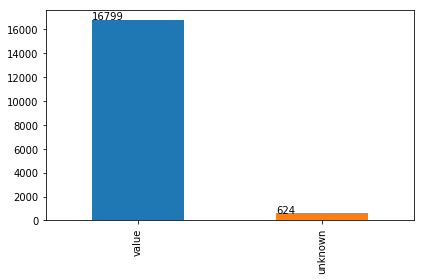

In [33]:
bar(df_catalog['desc'].apply(lambda x: 'unknown' if x == '?' else 'value'))

## Extract attributes: strong

In [34]:
def extract_strong(html):
  arr = []
  if pd.notnull(html):
    for element in bs(html).find_all('strong'):
      arr.append(element.get_text())
  return arr

df_catalog['strong'] = pd.Series(df_catalog['description'].apply(extract_strong), index=df_catalog.index)
display(df_catalog.filter(['strong']).head())

,strong
0,"[Firetrap Rhino Infant Boots, Firetrap boots, ..."
4,[]
5,[]
6,"[Dunlop Canvas High Top Trainers, Infant Train..."
7,[]


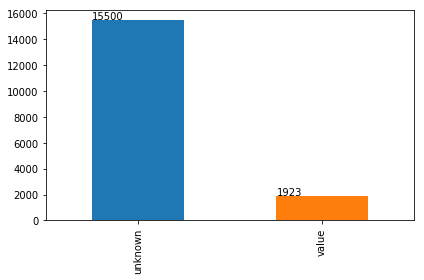

In [35]:
bar(df_catalog['strong'].apply(lambda x: 'value' if x else 'unknown'))

## Extract attributes: features

Bullet points with product properties.

In [36]:
def extract_features(html):
  arr = []
  if pd.notnull(html):
    # starts with "break line"
    for x in html.split('<br>'):
      # followed by "greater than"
      if x.startswith('>'):
        # can contain more, comma separated
        for feature in x.replace('<strong>','').replace('</strong>','').replace('>','').strip().split(', '):
          arr.append(feature)
  return arr

df_catalog['features'] = pd.Series(df_catalog['description'].apply(extract_features), index=df_catalog.index)
display(df_catalog.filter(['features']).head())

,features
0,"[Boys boots, Firetrap branding, Ankle height, ..."
4,"[Infant Girls, Full lace up, Air Max technolog..."
5,"[Lonsdale Camden Infant Boys Trainers, Lonsdal..."
6,"[Canvas Trainers, Lace up, Herringbone pattern..."
7,"[Kids canvas shoes, Elasticated laces, Texture..."


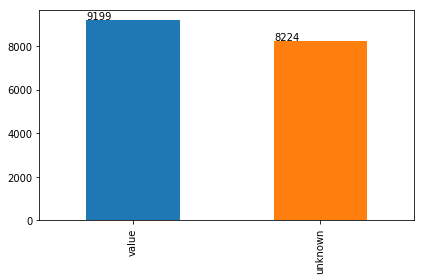

In [37]:
bar(df_catalog['features'].apply(lambda x: 'value' if x else 'unknown'))

## Brand

In [38]:
[print(brand) for brand in np.sort(df_catalog['brand'].unique())];

2117
4F
883 Police
ABLOOM
ALPINE PRO
AMERICAN CLUB
ANDY Z
ANESIA PARIS
ANNALISA
ARRIGO BELLO
AV
AX BOXING
AX Paris
Accessories
Adidas
Airwalk
Alesha Dixson
Amy Childs
Animal
Aqua Sphere
Arena
Ashworth
Asics
Atak
Azzurri
B&C 
BALADA
BBB
BEAUTY GIRL'S
BELLA PARIS
BELLA STAR
BELLE WOMEN
BELLO STAR
BEST SHOES
BESTELLE
BETLER
BIGBRANDSALE
BONA
Babolat
Back To School
Bafiz
Banana Moon
Beach Athletics
Ben Sherman
Beppi
Berghaus
Bernie Mev
Betty
Big Brand Sale
Bjorn Borg
Black Diamond
Blink
Blowfish
Briers
British Knights
Brogini
Bronx
Burton
CH. CREATION
CINK ME
CM PARIS
COCO PERLA
COMER
CONS
CORINA
COURA
CZASNABUTY
Callaway
Calvin Klein
Calvin Klein Underwear
Camelbak
Camping
Campri
Canterbury
Carlton
Casall
Case Scenario
Cayler and Sons
Champion
Character
Chervo
Chillaz
Christmas
Chub
Claudia
Colmar
Columbia
Converse
Cortica
Cosmic
Cote De Moi
Craft
Crafted
Crafted Essentials
Crafted Mini
Craghoppers
Creative Recreation
Crocs
Cruyff
Cupcake Cult
D555
DANIC
DC
DC Comics
DIAMANTIQUE
DIMAR
DOK

In [39]:
df_catalog['brand'].replace(to_replace='producent niezdefiniowany', value='?', inplace=True)

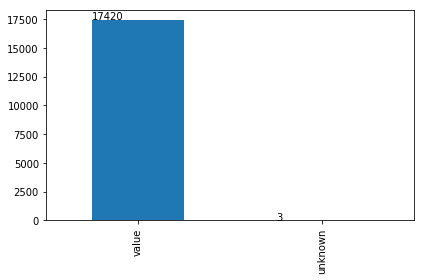

In [40]:
bar(df_catalog['brand'].apply(lambda x: 'unknown' if x == '?' else 'value'))

## Gender

In [41]:
df_catalog['gender'].unique()

array(['Child', 'Man', 'Woman', 'Unisex', 'Other'], dtype=object)

In [42]:
df_catalog[df_catalog['gender']=='Other']

,product_id,brand,gender,description,price,product_code,name,desc,strong,features
378,379,BELLE WOMEN,Other,"<table style=""border: 0pt solid #000000; heigh...",17.43,x379,The SIZE of the,The SIZE of the363738394041LENGTH CM2352425255...,"[The SIZE of the, LENGTH (CM), Heel: , Materia...",[]
379,380,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",18.83,x380,35,The size of theInsert the DL35225 cm36235 cm37...,"[35, 36, 37, 38, 39, 40, 41, ]",[]
380,381,NEW TLCK,Other,"<!-- TABELA 2 -->\n<table style=""width: 330px;...",8.33,x381,18,RozmiaryDł wkładkiRozmiaryDł wkładki1811 cm281...,"[18, 28, 19, 29, 20, 30, 21, 31, 22, 32, 23, 3...",[]
381,382,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",10.43,x382,35,The size of theThe length of the Insert35225 c...,"[35, 36, 37, 38, 39, 40, 41, , Material:]",[]
382,383,SERGIO TODZI,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",13.23,x383,35,The size of theThe length of the Insert35225 c...,"[35, 36, 37, 38, 39, 40, 41, ]",[]
383,384,AMERICAN CLUB,Other,"<!-- TABELA 2 -->\n<table style=""width: 330px;...",14.63,x384,18,RozmiaryDł wkładkiRozmiaryDł wkładki1811 cm281...,"[18, 28, 19, 29, 20, 30, 21, 31, 22, 32, 23, 3...",[]
384,385,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",19.53,x385,35,The size of theInsert the DL35225 cm36235 cm37...,"[35, 36, 37, 38, 39, 40, 41, ]",[]
385,386,VICES,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",15.33,x386,35,The size of theInsert the DL35225 cm36235 cm37...,"[35, 36, 37, 38, 39, 40, 41]",[]
386,387,TORNA,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",10.43,x387,35,The size of theInsert the DL3522 cm36225 cm372...,"[35, 36, 37, 38, 39, 40, 41]",[]
387,388,COMER,Other,"<!-- TABELA 1 -->\n<table style=""width: 330px;...",31.43,x388,35,The size of theThe length of the Insert35225 c...,"[35, 36, 37, 38, 39, 40, 41]",[]


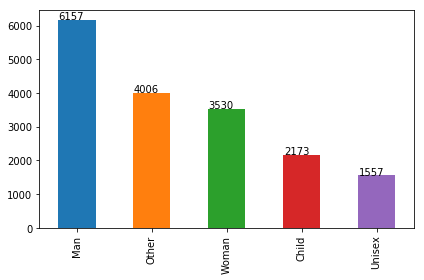

In [43]:
bar(df_catalog['gender'])

## Price

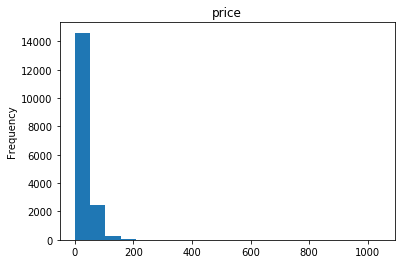

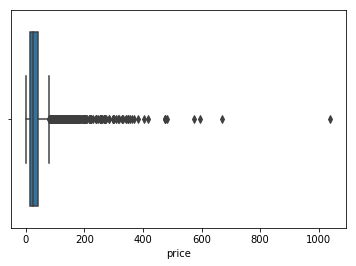

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


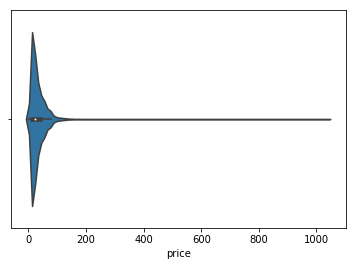

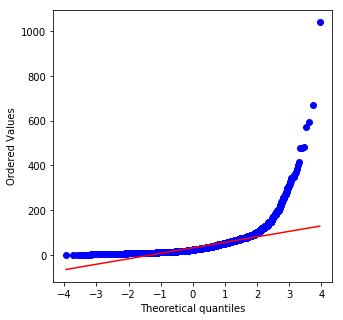

In [44]:
contplot(df_catalog['price'])

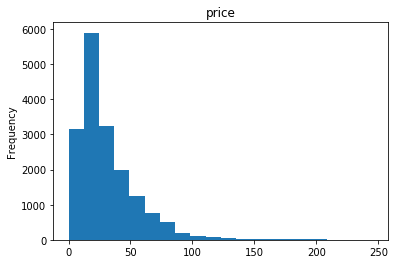

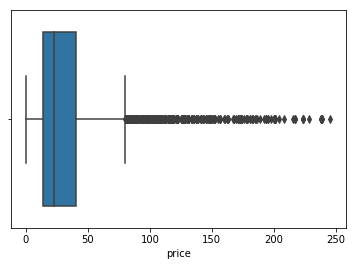

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


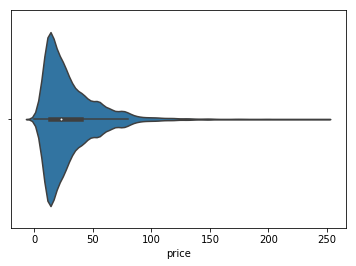

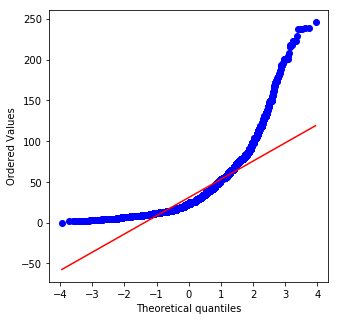

In [45]:
contplot(df_catalog[df_catalog['price']<250]['price'])

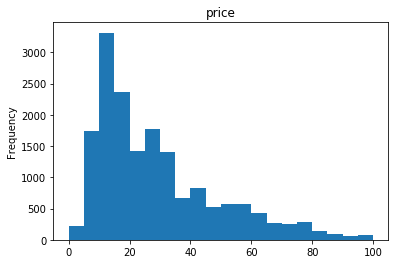

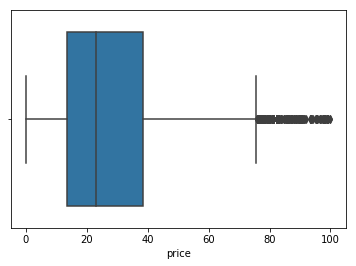

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


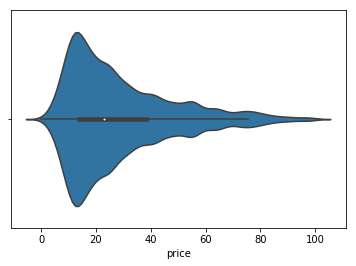

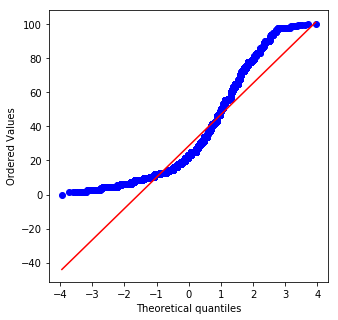

In [46]:
contplot(df_catalog[df_catalog['price']<100]['price'])

Now only sold products

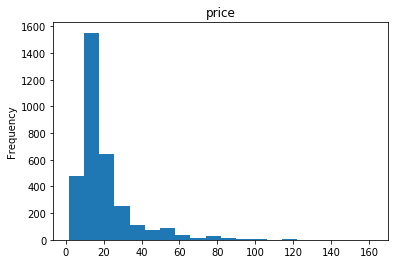

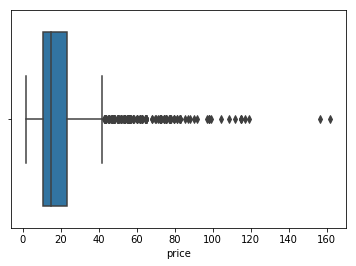

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


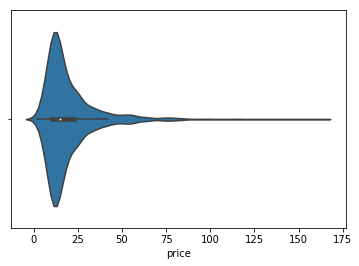

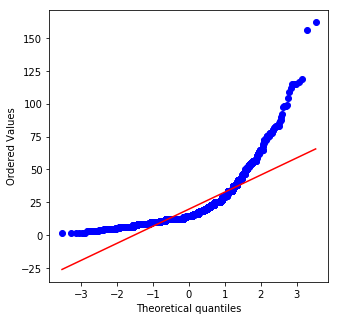

In [47]:
contplot(df_catalog[df_catalog['product_id'].isin(df_events[df_events['type']=='purchase_item']['product_id'])]['price'])

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


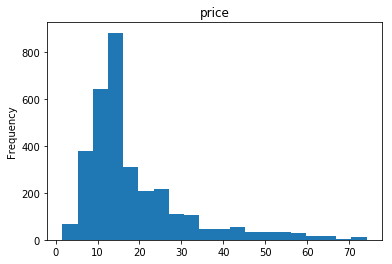

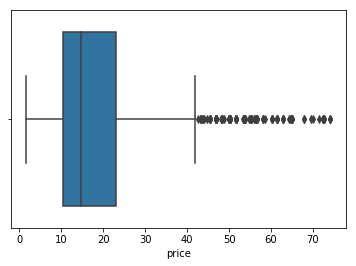

c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


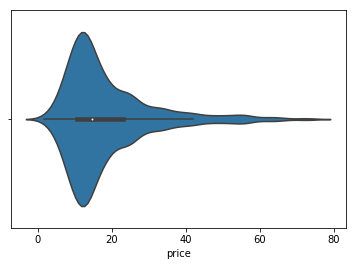

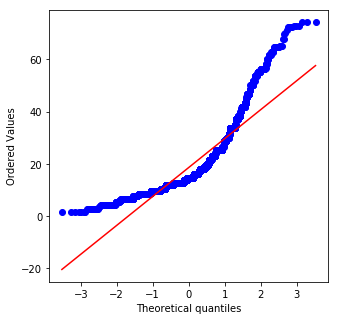

In [48]:
contplot(df_catalog[df_catalog['product_id'].isin(df_events[df_events['type']=='purchase_item']['product_id'])][df_catalog['price']<75]['price'])

Most products are cheap. Purchases per price category are proportional to its volume.

## Purchases

In [49]:
df_events['type'].value_counts()

view_product     592299
add_to_cart       46121
purchase_item     14705
Name: type, dtype: int64

In [50]:
print(df_events[df_events['type']=='purchase_item']['customer_id'].nunique(), end="")
print(' customers with a purchase')

5175 customers with a purchase


In [51]:
df_purchased = df_events[df_events['type']=='purchase_item'].merge(df_catalog, on='product_id', how='left', copy=False)

In [52]:
purchase_counts = df_purchased.groupby('product_id').size()
df_catalog['purchased'] = df_catalog['product_id'].apply(lambda x: purchase_counts[x] if x in purchase_counts.index else 0)

In [53]:
purchase_counts.sort_values(ascending=False).head(20)

product_id
3662     601
11219    372
26717    366
22030    311
3524     272
20581    247
20589    196
4230     195
23887    173
1027     167
16959    132
21410    129
3617     118
2934     113
22257    102
3477      93
24372     91
21926     90
23450     82
5930      80
dtype: int64

In [54]:
def best_sellers(n, filter_by=None, filter_value=None, exclude=[]):
    if filter_by is None:
        best_sellers = df_purchased[~df_purchased['product_id'].isin(exclude)].groupby('product_id').size().sort_values(ascending=False)
    else:
        best_sellers = df_purchased[~df_purchased['product_id'].isin(exclude)][df_purchased[filter_by]==filter_value].groupby('product_id').size().sort_values(ascending=False)
    return best_sellers[:n].keys().tolist()

# Elastic index

We propose and prepare following ElasticSearch index.

In [55]:
with open('index.txt') as f:
    print(f.read())

# create index
PUT rec
{
  "mappings": {
    "_doc": {
      "properties": {
        "brand": {
          "type": "keyword"
        },
        "gender": {
          "type": "keyword"
        },
        "price": {
          "type": "float"
        },
        "name": {
          "type": "text"
        },
        "desc": {
          "type": "text"
        },
        "strong": {
          "type": "text"
        },
        "features": {
          "type": "text"
        },
        "purchased": {
          "type": "integer",
          "null_value": 0
        }
      }
    }
  }
}



Dump Elastic with product catalog

In [56]:
NULL_CONSTANT = 'null'

def elastify_product(product):
    product_es = pd.Series.copy(product)

    product_es['product_id'] = str(product_es['product_id'])
    if product_es['brand'] == '?':
      product_es['brand'] = NULL_CONSTANT
    if product_es['name'] in ['?', '']:
      product_es['name'] = NULL_CONSTANT # .name leads to disgusting bug
    if product_es['desc'] in ['?', '']:
      product_es['desc'] = NULL_CONSTANT
    product_es['strong'] = ' '.join(product['strong']).strip()
    if product_es['strong'] == '':
      product_es['strong'] = NULL_CONSTANT
    product_es['features'] = ' '.join(product_es['features']).replace('"','').strip()
    if product_es['features'] == '':
      product_es['features'] = NULL_CONSTANT
    return product_es

In [57]:
FILE_PATH_BULK = 'bulk.json'
def prepare_bulk(df, file_path=FILE_PATH_BULK):
    with open(file_path, 'wb') as f:
      for _,row in df.iterrows():
        product = elastify_product(row)

        f.write('{{"index":{{"_index":"{}","_type":"_doc","_id":{}}}}}\n'
          .format(ELASTIC_INDEX, product['product_id'])
          .encode('utf8'))
        f.write('{{"brand":"{}","gender":"{}","price":{},"name":"{}","desc":"{}","strong":"{}","features":"{}","purchased":{}}}\n'
          .format(product['brand'], product['gender'], product['price'], product['name'], product['desc'], product['strong'], product['features'], product['purchased'])
          .replace("\"null\"", NULL_CONSTANT)
          .encode('utf8'))

In [58]:
# prepare_bulk(df_catalog)

In [59]:
with open(FILE_PATH_BULK) as f:
    for _ in range(6):
        print(f.readline())

{"index":{"_index":"rec","_type":"_doc","_id":1}}

{"brand":"Firetrap","gender":"Child","price":41.64,"name":"Firetrap Rhino Infant Boots","desc":"Firetrap Rhino Infant Boots These Firetrap Rhino Infant Boots provide excellent comfort thanks to a  padded ankle collar and tongue coupled with a lace up design for a secure fit The Firetrap boots benefit from Firetrap branding to outside and tongue of the boot and are finished off with a moulded outsole which provides a great level of grip and makes them great on any surface   Boys boots  Firetrap branding  Ankle height  Metallic eyelets  Stripy laces  Moulded outsole  Leather Upper Synthetic Sole Textile InnerFor our full range of Kids Trainers visit  Product code 020014","strong":"Firetrap Rhino Infant Boots Firetrap boots Boys boots","features":"Boys boots Firetrap branding Ankle height Metallic eyelets Stripy laces Moulded outsole Leather Upper Synthetic Sole Textile Inner","purchased":0}

{"index":{"_index":"rec","_type":"_doc","_id":

Windows users

In [60]:
# %%cmd
# curl -X POST http://localhost:9200/rec/_delete_by_query -H "Content-Type: application/json" -d "{"""query""":{"""match_all""":{}}}"

In [61]:
# %%cmd
# curl -X POST http://localhost:9200/rec/_bulk -H "Content-Type: application/json" --data-binary @bulk.json

Linux users

In [62]:
# %%bash
# curl -X POST 'localhost:9200/rec/_delete_by_query' -H 'Content-Type: application/json' -d '{"query":{"match_all":{}}}'

In [63]:
# %%bash
# curl -X POST 'localhost:9200/rec/_bulk' -H 'Content-Type: application/json' --data-binary @bulk.json

In [64]:
def es_q(product, match=[], fields_like=[], fields_in=[], exclude=[]):
    product_es = elastify_product(product)
    q = ~Q() # MatchNone()
    q2 = Q()
    # & is must
    # | is should
    if match:
        for col in match:
            if product_es[col] != NULL_CONSTANT:
                if col in ['brand', 'gender']:
                    # keyword
                    q2 = q2 & Q({"match": {col: product_es[col]}})
                else:
                    # text
                    q2 = q2 & MoreLikeThis(like=[product_es[col]],
                                             fields=[col],
                                             min_term_freq=1,
                                             min_doc_freq=1)
    if fields_like and fields_in:
        like = []
        for col in fields_like:
            if product_es[col] != NULL_CONSTANT:
                if col in ['brand', 'gender', 'name', 'desc']:
                    # string
                    like.append(product_es[col])
                elif col in ['features']:
                    # list of strings
                    like += product[col]
        if like:
            q2 = q2 & MoreLikeThis(like=like,
                                     fields=fields_in,
                                     min_term_freq=1,
                                     min_doc_freq=1)
    q = q | q2
    if exclude:
        for product_id in exclude:
            q = q & ~Q('match', _id=product_id)
    ### DEBUG
    if debug_on:
        print(product_es)
        print(q)
    ###
    return q

In [65]:
def es_recommend(products, sizes, match=[], fields_like=[], fields_in=[], exclude=[], sort_by_purchase=False):
    ms = MultiSearch(using=es, index=ELASTIC_INDEX)
    s = Search().sort({"purchased":{"order" : "desc"}}) if sort_by_purchase else Search()
    for product,size in zip(products,sizes):
        ms = ms.add(s[:size].query(es_q(product, match, fields_like, fields_in, exclude)))
    responses = ms.execute()
    ### DEBUG
    if debug_on:
        for hit in ms.execute()[0].hits:
            print(hit.meta.id)
            print(hit.to_dict())
    ###
    return [[int(hit.meta.id) for hit in response.hits] for response in responses] # make sure to convert to int!

# Recommender

In [66]:
# Change to True to see elastic request and hits example
debug_on = False

In [67]:
ks = [1,3,5,10]

In [68]:
def split_df(test='last_n', test_n=1):
    # choose from purchases only
    if test == 'last':
        # same as last_n with test_n=1
        df_test = df_purchased.sort_values(by='timestamp', ascending=False).drop_duplicates('customer_id')
    elif test == 'random':
        # test 1 random per customer
        df_test = df_purchased.iloc[randomState.permutation(np.arange(df_purchased.shape[0]))].drop_duplicates('customer_id')        
    elif test == 'last_n':
        # test n last per customer
        df_test = df_purchased.sort_values(by='timestamp', ascending=False).groupby('customer_id').filter(lambda x: len(x) >= test_n).groupby('customer_id').head(test_n)
    df_train = df_events[~df_events.index.isin(df_test.index)].sort_values(by='timestamp')
    return df_train, df_test

In [69]:
def dcg(rankings):
    dcg = 0
    for i,r in enumerate(rankings, start=1):
        if i==1:
            dcg += r
        else:
            dcg += r / np.log2(i)
    return dcg

In [70]:
DAY = 86400
MAX_RANKING = 2
def recommend(df_train, df_test, k=1, k_most_viewed=0, strategy='elastic', 
                   match=[], fields_like=[], fields_in=[], sort_by_purchase=False, ndcg=False):
    print('k = {}'.format(k))
    if k_most_viewed > 0:
        print('include {} most viewed'.format(k_most_viewed))
    
    hits = 0
    recommended = 0
    tested = 0#df_test['customer_id'].nunique()
    ndcg_count = 0.
    
    for customer_id,purchased in df_test.groupby('customer_id'):
        saw_before = df_train[(df_train['timestamp'] < np.min(purchased['timestamp']) - DAY / 2) & (df_train['customer_id']==customer_id)]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:k_most_viewed].tolist()
        if len(rec_products) < k:
            if strategy == 'skip':
                # warning: this does NOT test users without previous activity!
                continue
            elif strategy == 'best_seller':
                rec_products += best_sellers(k - len(rec_products), exclude=rec_products)
            elif len(saw_products)>0: # next startegies are based on previously seen
                if strategy == 'best_seller_by_gender':                    
                    saw_products_catalog = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
                    rec_products += best_sellers(k - len(rec_products), filter_by='gender', 
                                                 filter_value=np.max(saw_products_catalog['gender']), exclude=rec_products)
                elif strategy == 'best_seller_by_brand':
                    saw_products_catalog = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
                    rec_products += best_sellers(k - len(rec_products), filter_by='brand', 
                                                 filter_value=np.max(saw_products_catalog['brand']), exclude=rec_products)
                elif strategy == 'elastic':
                    saw_products_catalog = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
                    ideal_product = saw_products_catalog[saw_products_catalog['product_id']==saw_products.index[0]].iloc[0].copy()
                    rec_products += es_recommend([ideal_product], [k - len(rec_products)], 
                                                 match=match, fields_like=fields_like, fields_in=fields_in, 
                                                 exclude=rec_products, sort_by_purchase=sort_by_purchase)[0]
                    # TODO change to multi request - method already prepared, see es_recommend([product]...
                    # TODO but it will increase memory requirements.
                elif strategy == 'elastic_combined':
                    saw_products_catalog = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
                    ideal_product = saw_products_catalog[saw_products_catalog['product_id']==saw_products.index[0]].iloc[0].copy()
                    ideal_product['gender'] = np.max(saw_products_catalog['gender'])
                    ideal_product['brand'] = np.max(saw_products_catalog['brand'])
                    saw_products_catalog = saw_products_catalog[saw_products_catalog['product_id'].isin(saw_products.index[:3])]
                    ideal_product['features'] = list(set(saw_products_catalog['features'].sum()))
                    rec_products += es_recommend([ideal_product], [k - len(rec_products)], 
                                                 match=match, fields_like=fields_like, fields_in=fields_in, 
                                                 exclude=rec_products, sort_by_purchase=sort_by_purchase)[0]
#         if not rec_products: continue
        rec_products += [-1] * (k - len(rec_products))
        assert(len(rec_products)==k), 'Less than {} products recommended'.format(k)
        hits += sum(product in rec_products for product in purchased['product_id'].tolist()) # make sure comparing same types!
        recommended += len(rec_products)
        tested += 1
        
        if ndcg:
            documents = purchased.sort_values('timestamp').drop_duplicates('timestamp')
            timestamps = documents['timestamp'].tolist()
            purchased_ids = documents['product_id'].tolist()
            timerange = timestamps[-1] - timestamps[0]
            max_rankings = [MAX_RANKING - (ts - timestamps[0]) / timerange if ts!=timestamps[0] else MAX_RANKING for ts in timestamps]
            max_ndcg = dcg(max_rankings)
            rankings = []
            
            for product_id in rec_products:
                try:
                    rankings.append(max_rankings[purchased_ids.index(product_id)])
                except ValueError:
                    rankings.append(0)
            ndcg_count += dcg(rankings) / max_ndcg
    print('{} customers tested'.format(tested))
    print('hits: {} / {}'.format(hits, recommended))
    precision = hits / recommended
    print('{:.3%}'.format(precision))
    if ndcg:
        print('average nDCG {:.3%}'.format(ndcg_count / tested))
    print()

In [68]:
assert(0), 'End of definition, only runs follow further'

AssertionError: End of definition, only runs follow further

## test last vs. random

In [74]:
last_train, last_test = split_df(test='last')
randomState = np.random.RandomState(seed=42)
random_train, random_test = split_df(test='random')
print('Overlap {:.3%}'.format(2 * len(last_test.index.intersection(random_test.index)) / (len(last_test.index) + len(random_test.index))))

Overlap 57.720%


In [75]:
recommend(last_train, last_test, k_most_viewed=1, strategy='skip')

k = 1
include 1 most viewed
1938 customers tested
hits: 465 / 1938
23.994%



In [76]:
recommend(random_train, random_test, k_most_viewed=1, strategy='skip')

k = 1
include 1 most viewed
1838 customers tested
hits: 448 / 1838
24.374%



Roughly same so we continue with last as test set, so training set size is maximized.

# Experiments

## Best sellers

We talk about **global** best sellers, not only products seen by customer

In [77]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, strategy='best_seller') # this one is not personalized

k = 1
5175 customers tested
hits: 140 / 5175
2.705%

k = 3
2006 customers tested
hits: 649 / 6018
10.784%

k = 5
721 customers tested
hits: 508 / 3605
14.092%

k = 10
135 customers tested
hits: 238 / 1350
17.630%



In [78]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, strategy='best_seller_by_gender')

k = 1
5175 customers tested
hits: 51 / 5175
0.986%

k = 3
2006 customers tested
hits: 157 / 6018
2.609%

k = 5
721 customers tested
hits: 125 / 3605
3.467%

k = 10
135 customers tested
hits: 69 / 1350
5.111%



In [79]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, strategy='best_seller_by_brand')

k = 1
5175 customers tested
hits: 120 / 5175
2.319%

k = 3
2006 customers tested
hits: 174 / 6018
2.891%

k = 5
721 customers tested
hits: 117 / 3605
3.245%

k = 10
135 customers tested
hits: 55 / 1350
4.074%



## Most viewed

We talk about the most viewed **by customer**, not from the whole catalog

In [80]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, strategy='worst_scenario')

k = 1
include 1 most viewed
5175 customers tested
hits: 465 / 5175
8.986%

k = 3
include 1 most viewed
2006 customers tested
hits: 352 / 6018
5.849%

k = 3
include 3 most viewed
2006 customers tested
hits: 657 / 6018
10.917%

k = 5
include 1 most viewed
721 customers tested
hits: 168 / 3605
4.660%

k = 5
include 3 most viewed
721 customers tested
hits: 345 / 3605
9.570%

k = 5
include 5 most viewed
721 customers tested
hits: 425 / 3605
11.789%

k = 10
include 1 most viewed
135 customers tested
hits: 65 / 1350
4.815%

k = 10
include 3 most viewed
135 customers tested
hits: 105 / 1350
7.778%

k = 10
include 5 most viewed
135 customers tested
hits: 154 / 1350
11.407%

k = 10
include 10 most viewed
135 customers tested
hits: 190 / 1350
14.074%



## Most viewed + Best sellers

In [81]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, strategy='best_seller')

k = 1
include 1 most viewed
5175 customers tested
hits: 551 / 5175
10.647%

k = 3
include 1 most viewed
2006 customers tested
hits: 890 / 6018
14.789%

k = 3
include 3 most viewed
2006 customers tested
hits: 1079 / 6018
17.930%

k = 5
include 1 most viewed
721 customers tested
hits: 608 / 3605
16.865%

k = 5
include 3 most viewed
721 customers tested
hits: 711 / 3605
19.723%

k = 5
include 5 most viewed
721 customers tested
hits: 761 / 3605
21.110%

k = 10
include 1 most viewed
135 customers tested
hits: 269 / 1350
19.926%

k = 10
include 3 most viewed
135 customers tested
hits: 297 / 1350
22.000%

k = 10
include 5 most viewed
135 customers tested
hits: 331 / 1350
24.519%

k = 10
include 10 most viewed
135 customers tested
hits: 349 / 1350
25.852%



In [82]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, strategy='best_seller_by_gender')

k = 1
include 1 most viewed
5175 customers tested
hits: 465 / 5175
8.986%

k = 3
include 1 most viewed


c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


2006 customers tested
hits: 441 / 6018
7.328%

k = 3
include 3 most viewed
2006 customers tested
hits: 679 / 6018
11.283%

k = 5
include 1 most viewed
721 customers tested
hits: 255 / 3605
7.074%

k = 5
include 3 most viewed
721 customers tested
hits: 391 / 3605
10.846%

k = 5
include 5 most viewed
721 customers tested
hits: 454 / 3605
12.594%

k = 10
include 1 most viewed
135 customers tested
hits: 116 / 1350
8.593%

k = 10
include 3 most viewed
135 customers tested
hits: 155 / 1350
11.481%

k = 10
include 5 most viewed
135 customers tested
hits: 199 / 1350
14.741%

k = 10
include 10 most viewed
135 customers tested
hits: 224 / 1350
16.593%



In [83]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, strategy='best_seller_by_brand')

k = 1
include 1 most viewed
5175 customers tested
hits: 465 / 5175
8.986%

k = 3
include 1 most viewed


c:\users\pc\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


2006 customers tested
hits: 437 / 6018
7.262%

k = 3
include 3 most viewed
2006 customers tested
hits: 682 / 6018
11.333%

k = 5
include 1 most viewed
721 customers tested
hits: 237 / 3605
6.574%

k = 5
include 3 most viewed
721 customers tested
hits: 380 / 3605
10.541%

k = 5
include 5 most viewed
721 customers tested
hits: 442 / 3605
12.261%

k = 10
include 1 most viewed
135 customers tested
hits: 95 / 1350
7.037%

k = 10
include 3 most viewed
135 customers tested
hits: 133 / 1350
9.852%

k = 10
include 5 most viewed
135 customers tested
hits: 176 / 1350
13.037%

k = 10
include 10 most viewed
135 customers tested
hits: 202 / 1350
14.963%



## Elastic: match, combinations, search by most viewed

Brute force index properties exploration follows. Sort either by _score or purchase count

In [84]:
INDEX_ATTRS = ['brand', 'gender', 'name', 'features', 'desc']

In [85]:
for col in INDEX_ATTRS:
    print('\t', col)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col])

	 brand
k = 1
5175 customers tested
hits: 12 / 5175
0.232%

k = 3
2006 customers tested
hits: 12 / 6018
0.199%

k = 5
721 customers tested
hits: 9 / 3605
0.250%

k = 10
135 customers tested
hits: 10 / 1350
0.741%

	 gender
k = 1
5175 customers tested
hits: 0 / 5175
0.000%

k = 3
2006 customers tested
hits: 0 / 6018
0.000%

k = 5
721 customers tested
hits: 0 / 3605
0.000%

k = 10
135 customers tested
hits: 0 / 1350
0.000%

	 name
k = 1
5175 customers tested
hits: 180 / 5175
3.478%

k = 3
2006 customers tested
hits: 226 / 6018
3.755%

k = 5
721 customers tested
hits: 116 / 3605
3.218%

k = 10
135 customers tested
hits: 52 / 1350
3.852%

	 features
k = 1
5175 customers tested
hits: 178 / 5175
3.440%

k = 3
2006 customers tested
hits: 184 / 6018
3.057%

k = 5
721 customers tested
hits: 82 / 3605
2.275%

k = 10
135 customers tested
hits: 29 / 1350
2.148%

	 desc
k = 1
5175 customers tested
hits: 336 / 5175
6.493%

k = 3
2006 customers tested
hits: 361 / 6018
5.999%

k = 5
721 customers test

In [86]:
for col in INDEX_ATTRS:
    print('\t', col)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col], sort_by_purchase=True)

	 brand
k = 1
5175 customers tested
hits: 173 / 5175
3.343%

k = 3
2006 customers tested
hits: 326 / 6018
5.417%

k = 5
721 customers tested
hits: 213 / 3605
5.908%

k = 10
135 customers tested
hits: 104 / 1350
7.704%

	 gender
k = 1
5175 customers tested
hits: 78 / 5175
1.507%

k = 3
2006 customers tested
hits: 251 / 6018
4.171%

k = 5
721 customers tested
hits: 192 / 3605
5.326%

k = 10
135 customers tested
hits: 105 / 1350
7.778%

	 name
k = 1
5175 customers tested
hits: 60 / 5175
1.159%

k = 3
2006 customers tested
hits: 251 / 6018
4.171%

k = 5
721 customers tested
hits: 217 / 3605
6.019%

k = 10
135 customers tested
hits: 84 / 1350
6.222%

	 features
k = 1
5175 customers tested
hits: 66 / 5175
1.275%

k = 3
2006 customers tested
hits: 217 / 6018
3.606%

k = 5
721 customers tested
hits: 181 / 3605
5.021%

k = 10
135 customers tested
hits: 94 / 1350
6.963%

	 desc
k = 1
5175 customers tested
hits: 90 / 5175
1.739%

k = 3
2006 customers tested
hits: 233 / 6018
3.872%

k = 5
721 cust

In [87]:
for col, col2 in itertools.combinations(INDEX_ATTRS, 2):
    print('\t', col, '\t', col2)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col, col2])

	 brand 	 gender
k = 1
5175 customers tested
hits: 14 / 5175
0.271%

k = 3
2006 customers tested
hits: 41 / 6018
0.681%

k = 5
721 customers tested
hits: 17 / 3605
0.472%

k = 10
135 customers tested
hits: 20 / 1350
1.481%

	 brand 	 name
k = 1
5175 customers tested
hits: 187 / 5175
3.614%

k = 3
2006 customers tested
hits: 236 / 6018
3.922%

k = 5
721 customers tested
hits: 119 / 3605
3.301%

k = 10
135 customers tested
hits: 57 / 1350
4.222%

	 brand 	 features
k = 1
5175 customers tested
hits: 183 / 5175
3.536%

k = 3
2006 customers tested
hits: 191 / 6018
3.174%

k = 5
721 customers tested
hits: 90 / 3605
2.497%

k = 10
135 customers tested
hits: 33 / 1350
2.444%

	 brand 	 desc
k = 1
5175 customers tested
hits: 354 / 5175
6.841%

k = 3
2006 customers tested
hits: 380 / 6018
6.314%

k = 5
721 customers tested
hits: 192 / 3605
5.326%

k = 10
135 customers tested
hits: 76 / 1350
5.630%

	 gender 	 name
k = 1
5175 customers tested
hits: 205 / 5175
3.961%

k = 3
2006 customers tested
h

In [88]:
for col, col2 in itertools.combinations(INDEX_ATTRS, 2):
    print('\t', col, '\t', col2)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col, col2], sort_by_purchase=True)

	 brand 	 gender
k = 1
5175 customers tested
hits: 213 / 5175
4.116%

k = 3
2006 customers tested
hits: 333 / 6018
5.533%

k = 5
721 customers tested
hits: 200 / 3605
5.548%

k = 10
135 customers tested
hits: 107 / 1350
7.926%

	 brand 	 name
k = 1
5175 customers tested
hits: 191 / 5175
3.691%

k = 3
2006 customers tested
hits: 335 / 6018
5.567%

k = 5
721 customers tested
hits: 222 / 3605
6.158%

k = 10
135 customers tested
hits: 97 / 1350
7.185%

	 brand 	 features
k = 1
5175 customers tested
hits: 206 / 5175
3.981%

k = 3
2006 customers tested
hits: 320 / 6018
5.317%

k = 5
721 customers tested
hits: 220 / 3605
6.103%

k = 10
135 customers tested
hits: 104 / 1350
7.704%

	 brand 	 desc
k = 1
5175 customers tested
hits: 218 / 5175
4.213%

k = 3
2006 customers tested
hits: 334 / 6018
5.550%

k = 5
721 customers tested
hits: 208 / 3605
5.770%

k = 10
135 customers tested
hits: 90 / 1350
6.667%

	 gender 	 name
k = 1
5175 customers tested
hits: 89 / 5175
1.720%

k = 3
2006 customers tes

In [89]:
for cols in itertools.combinations(INDEX_ATTRS, 3):
    print('\t', cols)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=list(cols))

	 ('brand', 'gender', 'name')
k = 1
5175 customers tested
hits: 211 / 5175
4.077%

k = 3
2006 customers tested
hits: 230 / 6018
3.822%

k = 5
721 customers tested
hits: 118 / 3605
3.273%

k = 10
135 customers tested
hits: 60 / 1350
4.444%

	 ('brand', 'gender', 'features')
k = 1
5175 customers tested
hits: 211 / 5175
4.077%

k = 3
2006 customers tested
hits: 192 / 6018
3.190%

k = 5
721 customers tested
hits: 83 / 3605
2.302%

k = 10
135 customers tested
hits: 34 / 1350
2.519%

	 ('brand', 'gender', 'desc')
k = 1
5175 customers tested
hits: 382 / 5175
7.382%

k = 3
2006 customers tested
hits: 362 / 6018
6.015%

k = 5
721 customers tested
hits: 180 / 3605
4.993%

k = 10
135 customers tested
hits: 73 / 1350
5.407%

	 ('brand', 'name', 'features')
k = 1
5175 customers tested
hits: 204 / 5175
3.942%

k = 3
2006 customers tested
hits: 238 / 6018
3.955%

k = 5
721 customers tested
hits: 118 / 3605
3.273%

k = 10
135 customers tested
hits: 55 / 1350
4.074%

	 ('brand', 'name', 'desc')
k = 1
5

In [90]:
for cols in itertools.combinations(INDEX_ATTRS, 3):
    print('\t', cols)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=list(cols), sort_by_purchase=True)

	 ('brand', 'gender', 'name')
k = 1
5175 customers tested
hits: 229 / 5175
4.425%

k = 3
2006 customers tested
hits: 337 / 6018
5.600%

k = 5
721 customers tested
hits: 198 / 3605
5.492%

k = 10
135 customers tested
hits: 101 / 1350
7.481%

	 ('brand', 'gender', 'features')
k = 1
5175 customers tested
hits: 244 / 5175
4.715%

k = 3
2006 customers tested
hits: 336 / 6018
5.583%

k = 5
721 customers tested
hits: 198 / 3605
5.492%

k = 10
135 customers tested
hits: 105 / 1350
7.778%

	 ('brand', 'gender', 'desc')
k = 1
5175 customers tested
hits: 256 / 5175
4.947%

k = 3
2006 customers tested
hits: 345 / 6018
5.733%

k = 5
721 customers tested
hits: 191 / 3605
5.298%

k = 10
135 customers tested
hits: 98 / 1350
7.259%

	 ('brand', 'name', 'features')
k = 1
5175 customers tested
hits: 214 / 5175
4.135%

k = 3
2006 customers tested
hits: 327 / 6018
5.434%

k = 5
721 customers tested
hits: 216 / 3605
5.992%

k = 10
135 customers tested
hits: 96 / 1350
7.111%

	 ('brand', 'name', 'desc')
k = 

In [91]:
for cols in itertools.combinations(INDEX_ATTRS, 4):
    print('\t', cols)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=list(cols))

	 ('brand', 'gender', 'name', 'features')
k = 1
5175 customers tested
hits: 233 / 5175
4.502%

k = 3
2006 customers tested
hits: 235 / 6018
3.905%

k = 5
721 customers tested
hits: 110 / 3605
3.051%

k = 10
135 customers tested
hits: 57 / 1350
4.222%

	 ('brand', 'gender', 'name', 'desc')
k = 1
5175 customers tested
hits: 379 / 5175
7.324%

k = 3
2006 customers tested
hits: 361 / 6018
5.999%

k = 5
721 customers tested
hits: 177 / 3605
4.910%

k = 10
135 customers tested
hits: 74 / 1350
5.481%

	 ('brand', 'gender', 'features', 'desc')
k = 1
5175 customers tested
hits: 386 / 5175
7.459%

k = 3
2006 customers tested
hits: 362 / 6018
6.015%

k = 5
721 customers tested
hits: 177 / 3605
4.910%

k = 10
135 customers tested
hits: 67 / 1350
4.963%

	 ('brand', 'name', 'features', 'desc')
k = 1
5175 customers tested
hits: 354 / 5175
6.841%

k = 3
2006 customers tested
hits: 381 / 6018
6.331%

k = 5
721 customers tested
hits: 194 / 3605
5.381%

k = 10
135 customers tested
hits: 71 / 1350
5.259%

In [92]:
for cols in itertools.combinations(INDEX_ATTRS, 4):
    print('\t', cols)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=list(cols), sort_by_purchase=True)

	 ('brand', 'gender', 'name', 'features')
k = 1
5175 customers tested
hits: 253 / 5175
4.889%

k = 3
2006 customers tested
hits: 334 / 6018
5.550%

k = 5
721 customers tested
hits: 192 / 3605
5.326%

k = 10
135 customers tested
hits: 97 / 1350
7.185%

	 ('brand', 'gender', 'name', 'desc')
k = 1
5175 customers tested
hits: 262 / 5175
5.063%

k = 3
2006 customers tested
hits: 346 / 6018
5.749%

k = 5
721 customers tested
hits: 190 / 3605
5.270%

k = 10
135 customers tested
hits: 98 / 1350
7.259%

	 ('brand', 'gender', 'features', 'desc')
k = 1
5175 customers tested
hits: 262 / 5175
5.063%

k = 3
2006 customers tested
hits: 345 / 6018
5.733%

k = 5
721 customers tested
hits: 195 / 3605
5.409%

k = 10
135 customers tested
hits: 93 / 1350
6.889%

	 ('brand', 'name', 'features', 'desc')
k = 1
5175 customers tested
hits: 230 / 5175
4.444%

k = 3
2006 customers tested
hits: 342 / 6018
5.683%

k = 5
721 customers tested
hits: 209 / 3605
5.798%

k = 10
135 customers tested
hits: 92 / 1350
6.815%

In [93]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, match=INDEX_ATTRS)

k = 1
5175 customers tested
hits: 385 / 5175
7.440%

k = 3
2006 customers tested
hits: 362 / 6018
6.015%

k = 5
721 customers tested
hits: 177 / 3605
4.910%

k = 10
135 customers tested
hits: 68 / 1350
5.037%



In [94]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, match=INDEX_ATTRS, sort_by_purchase=True)

k = 1
5175 customers tested
hits: 267 / 5175
5.159%

k = 3
2006 customers tested
hits: 346 / 6018
5.749%

k = 5
721 customers tested
hits: 195 / 3605
5.409%

k = 10
135 customers tested
hits: 93 / 1350
6.889%



## Elastic: match, combinations, search by ideal product

In [95]:
IDEAL_ATTRS = [a for a in INDEX_ATTRS if a not in ['name', 'desc']]
IDEAL_ATTRS

['brand', 'gender', 'features']

In [96]:
for col in IDEAL_ATTRS:
    print('\t', col)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col], strategy='elastic_combined')

	 brand
k = 1
5175 customers tested
hits: 4 / 5175
0.077%

k = 3
2006 customers tested
hits: 4 / 6018
0.066%

k = 5
721 customers tested
hits: 1 / 3605
0.028%

k = 10
135 customers tested
hits: 0 / 1350
0.000%

	 gender
k = 1
5175 customers tested
hits: 0 / 5175
0.000%

k = 3
2006 customers tested
hits: 0 / 6018
0.000%

k = 5
721 customers tested
hits: 1 / 3605
0.028%

k = 10
135 customers tested
hits: 1 / 1350
0.074%

	 features
k = 1
5175 customers tested
hits: 167 / 5175
3.227%

k = 3
2006 customers tested
hits: 257 / 6018
4.271%

k = 5
721 customers tested
hits: 149 / 3605
4.133%

k = 10
135 customers tested
hits: 41 / 1350
3.037%



In [97]:
for col in IDEAL_ATTRS:
    print('\t', col)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col], sort_by_purchase=True, strategy='elastic_combined')

	 brand
k = 1
5175 customers tested
hits: 121 / 5175
2.338%

k = 3
2006 customers tested
hits: 179 / 6018
2.974%

k = 5
721 customers tested
hits: 115 / 3605
3.190%

k = 10
135 customers tested
hits: 54 / 1350
4.000%

	 gender
k = 1
5175 customers tested
hits: 51 / 5175
0.986%

k = 3
2006 customers tested
hits: 157 / 6018
2.609%

k = 5
721 customers tested
hits: 125 / 3605
3.467%

k = 10
135 customers tested
hits: 69 / 1350
5.111%

	 features
k = 1
5175 customers tested
hits: 63 / 5175
1.217%

k = 3
2006 customers tested
hits: 196 / 6018
3.257%

k = 5
721 customers tested
hits: 149 / 3605
4.133%

k = 10
135 customers tested
hits: 59 / 1350
4.370%



In [98]:
for col, col2 in itertools.combinations(INDEX_ATTRS, 2):
    print('\t', col, '\t', col2)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col, col2], strategy='elastic_combined')

	 brand 	 gender
k = 1
5175 customers tested
hits: 5 / 5175
0.097%

k = 3
2006 customers tested
hits: 17 / 6018
0.282%

k = 5
721 customers tested
hits: 6 / 3605
0.166%

k = 10
135 customers tested
hits: 6 / 1350
0.444%

	 brand 	 name
k = 1
5175 customers tested
hits: 91 / 5175
1.758%

k = 3
2006 customers tested
hits: 92 / 6018
1.529%

k = 5
721 customers tested
hits: 46 / 3605
1.276%

k = 10
135 customers tested
hits: 27 / 1350
2.000%

	 brand 	 features
k = 1
5175 customers tested
hits: 96 / 5175
1.855%

k = 3
2006 customers tested
hits: 92 / 6018
1.529%

k = 5
721 customers tested
hits: 49 / 3605
1.359%

k = 10
135 customers tested
hits: 9 / 1350
0.667%

	 brand 	 desc
k = 1
5175 customers tested
hits: 195 / 5175
3.768%

k = 3
2006 customers tested
hits: 167 / 6018
2.775%

k = 5
721 customers tested
hits: 71 / 3605
1.969%

k = 10
135 customers tested
hits: 24 / 1350
1.778%

	 gender 	 name
k = 1
5175 customers tested
hits: 142 / 5175
2.744%

k = 3
2006 customers tested
hits: 118 /

In [99]:
for col, col2 in itertools.combinations(INDEX_ATTRS, 2):
    print('\t', col, '\t', col2)
    for k in ks:
        train, test = split_df(test_n=k)
        recommend(train, test, k=k, match=[col, col2], sort_by_purchase=True, strategy='elastic_combined')

	 brand 	 gender
k = 1
5175 customers tested
hits: 110 / 5175
2.126%

k = 3
2006 customers tested
hits: 125 / 6018
2.077%

k = 5
721 customers tested
hits: 63 / 3605
1.748%

k = 10
135 customers tested
hits: 21 / 1350
1.556%

	 brand 	 name
k = 1
5175 customers tested
hits: 125 / 5175
2.415%

k = 3
2006 customers tested
hits: 173 / 6018
2.875%

k = 5
721 customers tested
hits: 105 / 3605
2.913%

k = 10
135 customers tested
hits: 43 / 1350
3.185%

	 brand 	 features
k = 1
5175 customers tested
hits: 121 / 5175
2.338%

k = 3
2006 customers tested
hits: 136 / 6018
2.260%

k = 5
721 customers tested
hits: 74 / 3605
2.053%

k = 10
135 customers tested
hits: 25 / 1350
1.852%

	 brand 	 desc
k = 1
5175 customers tested
hits: 135 / 5175
2.609%

k = 3
2006 customers tested
hits: 174 / 6018
2.891%

k = 5
721 customers tested
hits: 100 / 3605
2.774%

k = 10
135 customers tested
hits: 42 / 1350
3.111%

	 gender 	 name
k = 1
5175 customers tested
hits: 56 / 5175
1.082%

k = 3
2006 customers tested


This approach is blind path.

## Elastic: cross fields

In [100]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, fields_like=['features'], fields_in=['features']) # this is different from match features

k = 1
5175 customers tested
hits: 178 / 5175
3.440%

k = 3
2006 customers tested
hits: 184 / 6018
3.057%

k = 5
721 customers tested
hits: 82 / 3605
2.275%

k = 10
135 customers tested
hits: 29 / 1350
2.148%



In [101]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, fields_like=['features'], fields_in=['name'])

k = 1
5175 customers tested
hits: 17 / 5175
0.329%

k = 3
2006 customers tested
hits: 39 / 6018
0.648%

k = 5
721 customers tested
hits: 19 / 3605
0.527%

k = 10
135 customers tested
hits: 4 / 1350
0.296%



In [102]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, fields_like=['features'], fields_in=['desc'])

k = 1
5175 customers tested
hits: 163 / 5175
3.150%

k = 3
2006 customers tested
hits: 177 / 6018
2.941%

k = 5
721 customers tested
hits: 88 / 3605
2.441%

k = 10
135 customers tested
hits: 35 / 1350
2.593%



In [103]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, fields_like=['name'], fields_in=['desc'])

k = 1
5175 customers tested
hits: 144 / 5175
2.783%

k = 3
2006 customers tested
hits: 209 / 6018
3.473%

k = 5
721 customers tested
hits: 112 / 3605
3.107%

k = 10
135 customers tested
hits: 55 / 1350
4.074%



In [104]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, match=['desc'], fields_like=['gender'], fields_in=['gender','desc'])

k = 1
5175 customers tested
hits: 363 / 5175
7.014%

k = 3
2006 customers tested
hits: 342 / 6018
5.683%

k = 5
721 customers tested
hits: 171 / 3605
4.743%

k = 10
135 customers tested
hits: 71 / 1350
5.259%



In [105]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, match=['desc'], fields_like=['gender','brand'], fields_in=['gender','brand','desc'])

k = 1
5175 customers tested
hits: 374 / 5175
7.227%

k = 3
2006 customers tested
hits: 378 / 6018
6.281%

k = 5
721 customers tested
hits: 193 / 3605
5.354%

k = 10
135 customers tested
hits: 76 / 1350
5.630%



In [106]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, match=['features','desc'], 
                   fields_like=['gender','brand'], fields_in=['gender','brand','desc'])

k = 1
5175 customers tested
hits: 377 / 5175
7.285%

k = 3
2006 customers tested
hits: 379 / 6018
6.298%

k = 5
721 customers tested
hits: 194 / 3605
5.381%

k = 10
135 customers tested
hits: 70 / 1350
5.185%



In [107]:
for k in ks:
    train, test = split_df(test_n=k)
    recommend(train, test, k=k, match=['desc'], 
                   fields_like=['gender','brand','features'], fields_in=['gender','brand','desc'])

k = 1
5175 customers tested
hits: 374 / 5175
7.227%

k = 3
2006 customers tested
hits: 378 / 6018
6.281%

k = 5
721 customers tested
hits: 193 / 3605
5.354%

k = 10
135 customers tested
hits: 76 / 1350
5.630%



## Most viewed + Elastic

In [108]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, match=['desc'])

k = 1
include 1 most viewed
5175 customers tested
hits: 465 / 5175
8.986%

k = 3
include 1 most viewed
2006 customers tested
hits: 393 / 6018
6.530%

k = 3
include 3 most viewed
2006 customers tested
hits: 665 / 6018
11.050%

k = 5
include 1 most viewed
721 customers tested
hits: 192 / 3605
5.326%

k = 5
include 3 most viewed
721 customers tested
hits: 358 / 3605
9.931%

k = 5
include 5 most viewed
721 customers tested
hits: 430 / 3605
11.928%

k = 10
include 1 most viewed
135 customers tested
hits: 76 / 1350
5.630%

k = 10
include 3 most viewed
135 customers tested
hits: 116 / 1350
8.593%

k = 10
include 5 most viewed
135 customers tested
hits: 159 / 1350
11.778%

k = 10
include 10 most viewed
135 customers tested
hits: 190 / 1350
14.074%



In [109]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, match=['brand', 'gender', 'desc'])

k = 1
include 1 most viewed
5175 customers tested
hits: 465 / 5175
8.986%

k = 3
include 1 most viewed
2006 customers tested
hits: 373 / 6018
6.198%

k = 3
include 3 most viewed
2006 customers tested
hits: 659 / 6018
10.950%

k = 5
include 1 most viewed
721 customers tested
hits: 180 / 3605
4.993%

k = 5
include 3 most viewed
721 customers tested
hits: 351 / 3605
9.736%

k = 5
include 5 most viewed
721 customers tested
hits: 427 / 3605
11.845%

k = 10
include 1 most viewed
135 customers tested
hits: 74 / 1350
5.481%

k = 10
include 3 most viewed
135 customers tested
hits: 114 / 1350
8.444%

k = 10
include 5 most viewed
135 customers tested
hits: 157 / 1350
11.630%

k = 10
include 10 most viewed
135 customers tested
hits: 190 / 1350
14.074%



In [110]:
for k in ks:
    for k_most_viewed in ks:
        train, test = split_df(test_n=k)
        if k >= k_most_viewed:
            recommend(train, test, k=k, k_most_viewed=k_most_viewed, match=['desc'], fields_like=['gender','brand'], fields_in=['gender','brand','desc'])

k = 1
include 1 most viewed
5175 customers tested
hits: 465 / 5175
8.986%

k = 3
include 1 most viewed
2006 customers tested
hits: 390 / 6018
6.481%

k = 3
include 3 most viewed
2006 customers tested
hits: 664 / 6018
11.034%

k = 5
include 1 most viewed
721 customers tested
hits: 193 / 3605
5.354%

k = 5
include 3 most viewed
721 customers tested
hits: 358 / 3605
9.931%

k = 5
include 5 most viewed
721 customers tested
hits: 430 / 3605
11.928%

k = 10
include 1 most viewed
135 customers tested
hits: 77 / 1350
5.704%

k = 10
include 3 most viewed
135 customers tested
hits: 116 / 1350
8.593%

k = 10
include 5 most viewed
135 customers tested
hits: 159 / 1350
11.778%

k = 10
include 10 most viewed
135 customers tested
hits: 190 / 1350
14.074%



## nDCG

In [111]:
recommend(train, test, k=10, match=['desc'], ndcg=True)

k = 10
135 customers tested
hits: 73 / 1350
5.407%
average nDCG 3.512%



In [112]:
recommend(train, test, k=10, k_most_viewed=5, match=['desc'], ndcg=True)

k = 10
include 5 most viewed
135 customers tested
hits: 159 / 1350
11.778%
average nDCG 7.094%



In [113]:
recommend(train, test, k=10, match=['desc'], fields_like=['gender','brand'], fields_in=['gender','brand','desc'], ndcg=True)

k = 10
135 customers tested
hits: 76 / 1350
5.630%
average nDCG 3.812%



In [114]:
assert(0), 'You reached the end. Congratulation!!'

AssertionError: You reached the end. Congratulation!!

# Challenge

Comments on challenge are in documentation, here only scripts archived.

In [71]:
K = 10

In [72]:
customer_ids = pd.read_csv('challenge/vi_challenge_uID.csv', dtype=int).iloc[:,0]
print(len(customer_ids))
print(customer_ids.nunique())

138
138


In [ ]:
with open('challenge/submit_es1.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            saw_products_catalog = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
            ideal_product = saw_products_catalog[saw_products_catalog['product_id']==saw_products.index[0]].iloc[0].copy()
            rec_products += es_recommend([ideal_product], [K - len(rec_products)], 
                                         match=['desc'],
                                         exclude=rec_products)[0]
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [77]:
with open('challenge/submit_es2.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        saw_products_catalog = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
        ideal_product = saw_products_catalog[saw_products_catalog['product_id']==saw_products.index[0]].iloc[0].copy()
        rec_products = es_recommend([ideal_product], [K], 
                                     match=['desc'],
                                     exclude=rec_products)[0]
        if len(rec_products) < K:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
with open('challenge/submit.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
with open('challenge/submit2.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    rec_products = best_sellers(K)
    assert(len(rec_products) == K)
    assert(pd.Series(rec_products).nunique()==K)
    for customer_id in customer_ids:
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
K_limit = int(K/2)
with open('challenge/submit3.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K_limit].tolist()
        assert(len(rec_products) <= K/2)
        rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
K_limit = int(K/2)
with open('challenge/submit4.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K_limit].tolist()
        assert(len(rec_products) <= K/2)
        purchased_products = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
        rec_products += best_sellers(K - len(rec_products), filter_by='gender', filter_value=np.max(purchased_products['gender']), exclude=rec_products)
        if len(rec_products) < k:
            rec_products += best_sellers(k - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
K_limit = int(K/2)
with open('challenge/submit5.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K_limit].tolist()
        assert(len(rec_products) <= K/2)
        purchased_products = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
        rec_products += best_sellers(K - len(rec_products), filter_by='brand', filter_value=np.max(purchased_products['brand']), exclude=rec_products)
        if len(rec_products) < k:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
with open('challenge/submit6.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        rec_products = df_catalog[df_catalog['product_id'].isin(rec_products)].sort_values('purchased', ascending=False)['product_id'].tolist()
        if len(rec_products) < K:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
with open('challenge/submit7.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        rec_products = df_catalog[df_catalog['product_id'].isin(rec_products)].sort_values('purchased', ascending=False)['product_id'].tolist()
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
with open('challenge/submit8.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            purchased_products = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
            rec_products += best_sellers(K - len(rec_products), filter_by='brand', filter_value=np.max(purchased_products['brand']), exclude=rec_products)
        if len(rec_products) < K:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
with open('challenge/submit9.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = df_events[df_events['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            purchased_products = df_catalog[df_catalog['product_id'].isin(saw_products.index)]
            rec_products += best_sellers(K - len(rec_products), filter_by='gender', filter_value=np.max(purchased_products['gender']), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
dfe = pd.read_csv('data/vi_dataset_events.csv')
with open('challenge/submit10.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = dfe[dfe['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += best_sellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
dfp = dfe[dfe['type']=='purchase_item']

def bsellers(n, filter_by=None, filter_value=None, exclude=[]):
    if filter_by is None:
        best_sellers = dfp[~dfp['product_id'].isin(exclude)].groupby('product_id').size().sort_values(ascending=False)
    else:
        best_sellers = dfp[~dfp['product_id'].isin(exclude)][dfp[filter_by]==filter_value].groupby('product_id').size().sort_values(ascending=False)
    return best_sellers[:n].keys().tolist()

with open('challenge/submit11.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = dfe[dfe['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += bsellers(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
def mcommon(n, filter_by=None, filter_value=None, exclude=[]):
    if filter_by is None:
        mcommon = dfe[~dfe['product_id'].isin(exclude)].groupby('product_id').size().sort_values(ascending=False)
    else:
        mcommon = dfe[~dfe['product_id'].isin(exclude)][dfe[filter_by]==filter_value].groupby('product_id').size().sort_values(ascending=False)
    return mcommon[:n].keys().tolist()

with open('challenge/submit12.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = dfe[dfe['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += mcommon(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
dfv = dfe[dfe['type']=='view_product']

def mviewed(n, filter_by=None, filter_value=None, exclude=[]):
    if filter_by is None:
        mviewed = dfv[~dfv['product_id'].isin(exclude)].groupby('product_id').size().sort_values(ascending=False)
    else:
        mviewed = dfv[~dfv['product_id'].isin(exclude)][dfv[filter_by]==filter_value].groupby('product_id').size().sort_values(ascending=False)
    return mviewed[:n].keys().tolist()

with open('challenge/submit13.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = dfe[dfe['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += mviewed(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))

In [ ]:
dfc = dfe[dfe['type']=='add_to_cart']

def mcart(n, filter_by=None, filter_value=None, exclude=[]):
    if filter_by is None:
        mcart = dfc[~dfc['product_id'].isin(exclude)].groupby('product_id').size().sort_values(ascending=False)
    else:
        mcart = dfc[~dfc['product_id'].isin(exclude)][dfc[filter_by]==filter_value].groupby('product_id').size().sort_values(ascending=False)
    return mcart[:n].keys().tolist()

with open('challenge/submit14.csv', 'wb') as f:
    f.write('customer_id,product_id\n'.encode('utf8'))
    for customer_id in customer_ids:
        saw_before = dfe[dfe['customer_id']==customer_id]
        saw_products = saw_before['product_id'].value_counts()
        rec_products = saw_products.index[:K].tolist()
        if len(rec_products) < K:
            rec_products += mcart(K - len(rec_products), exclude=rec_products)
        assert(len(rec_products) == K)
        assert(pd.Series(rec_products).nunique()==K)
        for product_id in rec_products:
            f.write('{},{}\n'.format(customer_id, product_id).encode('utf8'))